In [1]:
!pip install timm
!pip install lightning
!pip install rasterio
!pip install torchmetrics
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.6 MB/s eta 0:00:00


In [2]:
import torch
import rasterio
import timm
import torch.nn as nn
import lightning as L
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchinfo import summary
import joblib
from google.colab import drive
import sys
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil

In [4]:
drive.mount("/content/drive")
current_dir = "/content/drive/MyDrive/teg_resnet18_arroz/03_modelo/"
directory_to_add = current_dir
sys.path.append(directory_to_add)

seed = 42
#normalization = "mm"
normalization = "z"
dataset_dir = "/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/"
master_file_csv = os.path.join(dataset_dir, "file_labeled_filtrado.csv")
#dataset_unknown_100_csv = f"sample_100_seed{seed}.csv"
#dataset_known_train_csv = f"rest_seed{seed}.csv"
dataset_images_path = os.path.join(dataset_dir, "images")
dataset_unknown_100_csv = os.path.join(dataset_dir, f"sample_100_seed{seed}.csv")
dataset_known_train_csv = os.path.join(dataset_dir, f"rest_seed{seed}.csv" )
path_dataset_filtered_norm_csv = os.path.join(dataset_dir, f"filtered_labeled_file_2244_norm_{normalization}_seed{seed}.csv")

Mounted at /content/drive


In [5]:
import utils

In [6]:
df = pd.read_csv(master_file_csv)
df_sample = df.sample(n=100, random_state=seed)
df_rest = df.drop(df_sample.index)

df_sample.to_csv(dataset_unknown_100_csv, index=False)
df_rest.to_csv(dataset_known_train_csv, index=False)

print(f"Archivos '{dataset_unknown_100_csv}' y '{dataset_known_train_csv}' creados con éxito.")

Archivos '/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/sample_100_seed42.csv' y '/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/rest_seed42.csv' creados con éxito.


Normalizacion de las etiquetas en el csv

In [6]:
df = pd.read_csv(os.path.join(dataset_dir, dataset_known_train_csv))
labels = df["label"].values.reshape(-1, 1)

if normalization == "mm":
  scaler_mm = MinMaxScaler()
  labels_norm = scaler_mm.fit_transform(labels)
  scaler_path = os.path.join(dataset_dir, "scaler_mm.pkl")
  joblib.dump(scaler_mm, scaler_path)
else:
  scaler_z = StandardScaler()
  labels_norm = scaler_z.fit_transform(labels)
  scaler_path = os.path.join(dataset_dir, "scaler_z.pkl")
  joblib.dump(scaler_z, scaler_path)

dataset_filtered_norm_csv = os.path.join(dataset_dir, f"rest_norm_{normalization}_seed{seed}.csv")
df["produccion_norm"] = labels_norm
df.to_csv(dataset_filtered_norm_csv, index=False)
print(f"Se guardo: {dataset_filtered_norm_csv}")

Se guardo: /content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/rest_norm_z_seed19.csv


In [7]:
dfn = pd.read_csv(dataset_filtered_norm_csv)

# Cambia los nombres
dfn = dfn.rename(columns={
    'label': 'prod',
    'produccion_norm': 'label'
})

# Guarda el resultado en otro archivo o sobreescribe
dfn.to_csv(path_dataset_filtered_norm_csv, index=False)

In [8]:
BATCH_SIZE = 64

In [9]:
resnet18_model = timm.create_model("resnet18", pretrained=False, in_chans=10, num_classes=1)

In [10]:
summary(
    resnet18_model,
    input_size=(BATCH_SIZE, 10, 64, 64),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet (ResNet)                          [64, 10, 64, 64]          [64, 1]                   --                        --                        --
├─Conv2d (conv1)                         [64, 10, 64, 64]          [64, 64, 32, 32]          31,360                    [7, 7]                    2,055,208,960
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]          [64, 64, 32, 32]          128                       --                        8,192
├─ReLU (act1)                            [64, 64, 32, 32]          [64, 64, 32, 32]          --                        --                        --
├─MaxPool2d (maxpool)                    [64, 64, 32, 32]          [64, 64, 16, 16]          --                        3                         --
├─Sequential (layer1)                    [64, 64, 16, 16]          [64, 64, 16, 16]        

In [11]:
concat_seasons_dataset_list = utils.Sentinel2ConcatSeasonsRegressionDataset(
        folder_path=dataset_images_path,
        csv=path_dataset_filtered_norm_csv
    )
print(concat_seasons_dataset_list)

0 ; -1.7166379863379384
1 ; -1.6395397508093743
2 ; 0.4068761692933243
3 ; -0.7403567338680296
4 ; -0.8641463024462304
5 ; -1.128288832581405
6 ; -0.8327630315390809
7 ; 1.2829924821179146
8 ; -0.1371005264306003
9 ; -1.1997729496476903
10 ; -0.2225327639000628
11 ; 0.9351612295636744
12 ; -1.2084905248996762
13 ; 0.2952912060679039
14 ; -1.2250539178784496
15 ; -0.8641463024462304
16 ; -1.0724963509686951
17 ; -0.9469632673400972
18 ; -1.027164959658368
19 ; -1.3235625182258912
20 ; -1.0106015666795949
21 ; -0.3960125114145837
22 ; 0.2028849083968525
23 ; -0.9051189061305644
24 ; -0.7028711602844899
25 ; 0.0233028582059415
26 ; -0.0891538625446775
27 ; 0.8052693583090832
28 ; 0.0189440705799485
29 ; -0.8885555131517912
30 ; 0.4617968933808359
31 ; -1.098649076724653
32 ; -0.3140673040459156
33 ; -0.4021148140909739
34 ; 1.5366739219507064
35 ; 1.4817531978631946
36 ; 1.0258240121843285
37 ; 0.0363792210839205
38 ; 1.4407805941788605
39 ; 1.4163713834732998
40 ; 1.4093973232717112
41 ;

In [12]:
print(len(concat_seasons_dataset_list))

2244


In [13]:
dataset = concat_seasons_dataset_list
dataset_size = len(concat_seasons_dataset_list)

In [14]:
train_size = int(0.8 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
print(f"Train size: {train_size}. Validation size: {val_size}. Test size: {test_size}.")

Train size: 1795. Validation size: 336. Test size: 113.


In [15]:
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

print(f"Train size: {len(train_dataset)}. Validation size: {len(val_dataset)}. Test size: {len(test_dataset)}.")

Train size: 1795. Validation size: 336. Test size: 113.


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
#print(f"Train size: {len(train_dataloader)}. Validation size: {len(val_dataloader)}. Test size: {len(test_dataloader)}.")
print(f"Training batches: {len(train_dataloader)}. Validation batches: {len(val_dataloader)}. Test batches: {len(test_dataloader)}.")
print(f"Train size: {len(train_dataloader) * BATCH_SIZE}. Validation size: {len(val_dataloader) * BATCH_SIZE}. Test size: {len(test_dataloader) * BATCH_SIZE}.")

Training batches: 28. Validation batches: 6. Test batches: 2.
Train size: 1792. Validation size: 384. Test size: 128.


In [17]:
class LightningRegressionTask(L.LightningModule):
    def __init__(self, model, model_name, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        #self.criterion = nn.MSELoss() # Cambiar perdida
        self.criterion = nn.HuberLoss()
        self.learning_rate = learning_rate
        self.name = model_name

        # Métricas de regresión
        self.mse = torchmetrics.MeanSquaredError()
        self.rmse = torchmetrics.MeanSquaredError(squared=False)
        self.mae = torchmetrics.MeanAbsoluteError()
        self.r2 = torchmetrics.R2Score()

        self.scaler = joblib.load(scaler_path)

        # Diccionarios de logs
        self.train_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.val_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.test_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}

        self.train_step_loss_logs = {"step_loss": []}
        self.val_step_loss_logs = {"step_loss": []}
        self.test_step_loss_logs = {"step_loss": []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1) # Asegúrate de que las dimensiones coincidan
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        # Log de métricas
        self.log("train_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.train_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_train_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.train_logs["epoch"].append(epoch)
        self.train_logs["loss"].append(self.trainer.callback_metrics["train_loss"].item())
        self.train_logs["mse"].append(self.trainer.callback_metrics["train_mse"].item())
        self.train_logs["rmse"].append(self.trainer.callback_metrics["train_rmse"].item())
        self.train_logs["mae"].append(self.trainer.callback_metrics["train_mae"].item())
        self.train_logs["r2"].append(self.trainer.callback_metrics["train_r2"].item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("val_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.val_logs["epoch"].append(epoch)
        self.val_logs["loss"].append(self.trainer.callback_metrics["val_loss"].item())
        self.val_logs["mse"].append(self.trainer.callback_metrics["val_mse"].item())
        self.val_logs["rmse"].append(self.trainer.callback_metrics["val_rmse"].item())
        self.val_logs["mae"].append(self.trainer.callback_metrics["val_mae"].item())
        self.val_logs["r2"].append(self.trainer.callback_metrics["val_r2"].item())

    def on_fit_end(self):
        # Export logs
        train_logs_df = pd.DataFrame(self.train_logs)
        train_step_loss_logs_df = pd.DataFrame(self.train_step_loss_logs)
        train_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/training_logs_{self.name}.csv", index=False)
        train_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/training_step_loss_logs_{self.name}.csv", index=False)

        val_logs_df = pd.DataFrame(self.val_logs)
        val_step_loss_logs_df = pd.DataFrame(self.val_step_loss_logs)
        val_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/validation_logs_{self.name}.csv", index=False)
        val_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/validation_step_loss_logs_{self.name}.csv", index=False)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("test_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.test_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_test_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.test_logs["epoch"].append(epoch)
        self.test_logs["loss"].append(self.trainer.callback_metrics["test_loss"].item())
        self.test_logs["mse"].append(self.trainer.callback_metrics["test_mse"].item())
        self.test_logs["rmse"].append(self.trainer.callback_metrics["test_rmse"].item())
        self.test_logs["mae"].append(self.trainer.callback_metrics["test_mae"].item())
        self.test_logs["r2"].append(self.trainer.callback_metrics["test_r2"].item())

    def on_test_end(self):
        test_logs_df = pd.DataFrame(self.test_logs)
        test_step_loss_logs_df = pd.DataFrame(self.test_step_loss_logs)
        test_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/test_logs_{self.name}.csv", index=False)
        test_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/test_step_loss_logs_{self.name}.csv", index=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def predict_step(self, batch, batch_idx):
      x = batch if len(batch) == 1 else batch[0]
      y_pred_norm = self(x)
      if self.scaler:
          y_pred_real = self.scaler.inverse_transform(y_pred_norm.detach().cpu().numpy())
          return y_pred_real
      return y_pred_norm

In [18]:
lightning_resnet18_model = LightningRegressionTask(resnet18_model, "resnet18", learning_rate=0.001)

In [19]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=True)
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
        filename="{epoch}-{val_rmse:.2f}-{val_loss:.2f}",
        mode="min", monitor="val_loss",
        save_last=True
)

In [20]:
trainer = L.Trainer(
    max_epochs=100,  # Number of epochs to train
    accelerator="gpu",  # Use GPU if available, or "cpu" for CPU
    devices=1,  # Number of GPUs to use (set to 1 for a single GPU)
    log_every_n_steps=50,  # Log metrics every 50 steps
    callbacks=[early_stopping, checkpoint_callback],  # Set callbacks
    default_root_dir=f"logs-resnet18_{normalization}_{seed}/"
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [21]:
trainer.fit(lightning_resnet18_model, train_dataloader, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | criterion | HuberLoss         | 0      | train
2 | mse       | MeanSquaredError  | 0      | train
3 | rmse      | MeanSquaredError  | 0      | train
4 | mae       | MeanAbsoluteError | 0      | train
5 | r2        | R2Score           | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.796    Total estimated model params size (MB)
99        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.108
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.108


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.057
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.057


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.052
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.052


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.049
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.049. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.049. Signaling Trainer to stop.


In [22]:
trainer.test(lightning_resnet18_model, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04803548380732536    │
│         test_mae          │    0.22621268033981323    │
│         test_mse          │    0.10151245445013046    │
│          test_r2          │    0.8921189904212952     │
│         test_rmse         │    0.3180620074272156     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04803548380732536,
  'test_mse': 0.10151245445013046,
  'test_rmse': 0.3180620074272156,
  'test_mae': 0.22621268033981323,
  'test_r2': 0.8921189904212952}]

In [23]:
folder = f'logs-resnet18_{normalization}_{seed}/'
output = f'/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_{normalization}_seed_{seed}'
os.makedirs(output, exist_ok=True)
shutil.copytree(folder, output, dirs_exist_ok=True)

'/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19'

In [24]:
logs_path = output

Gráfica loss guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/loss.png


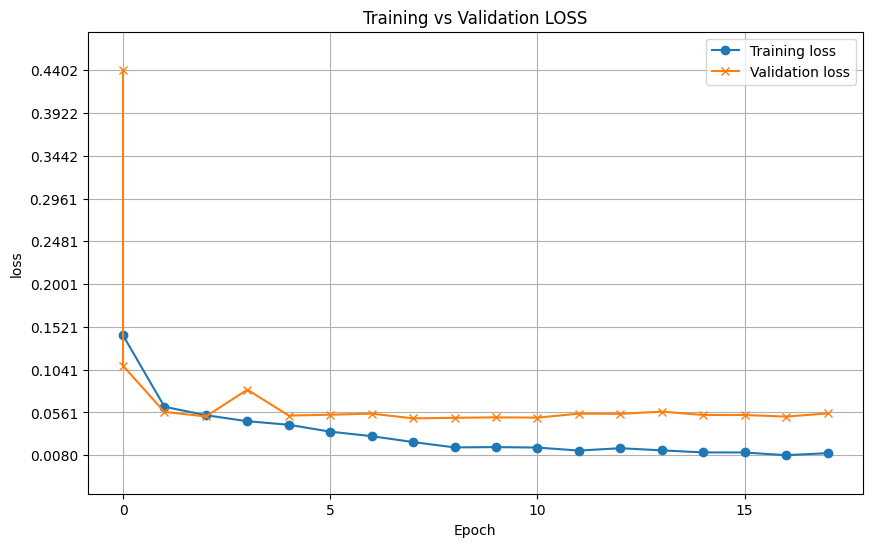

Gráfica mse guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/mse.png


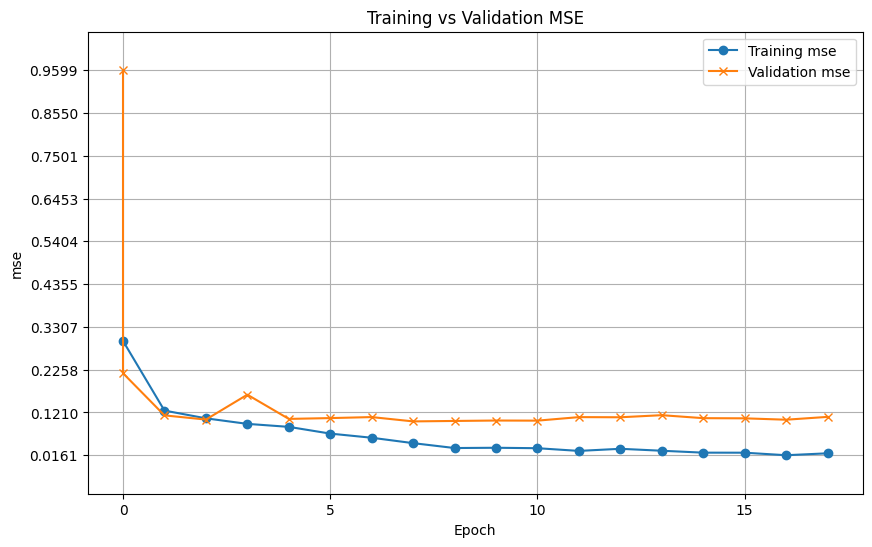

Gráfica rmse guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/rmse.png


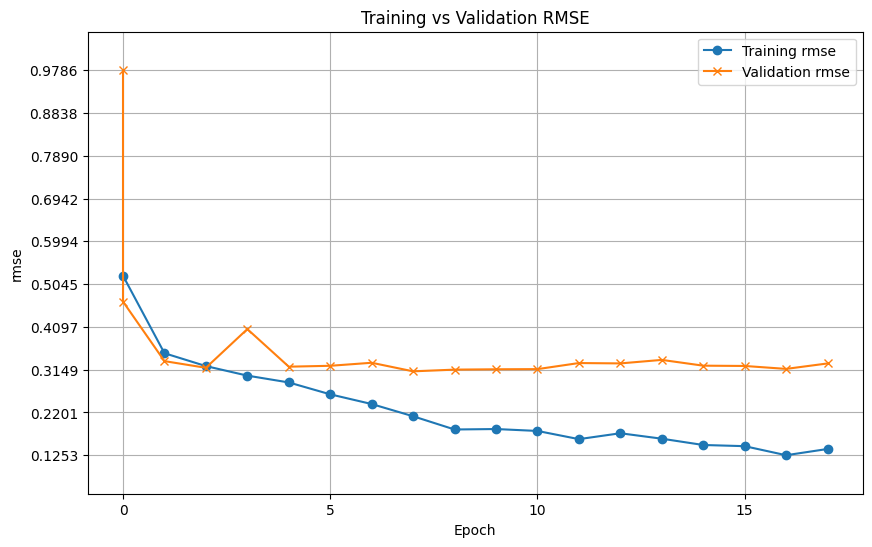

Gráfica mae guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/mae.png


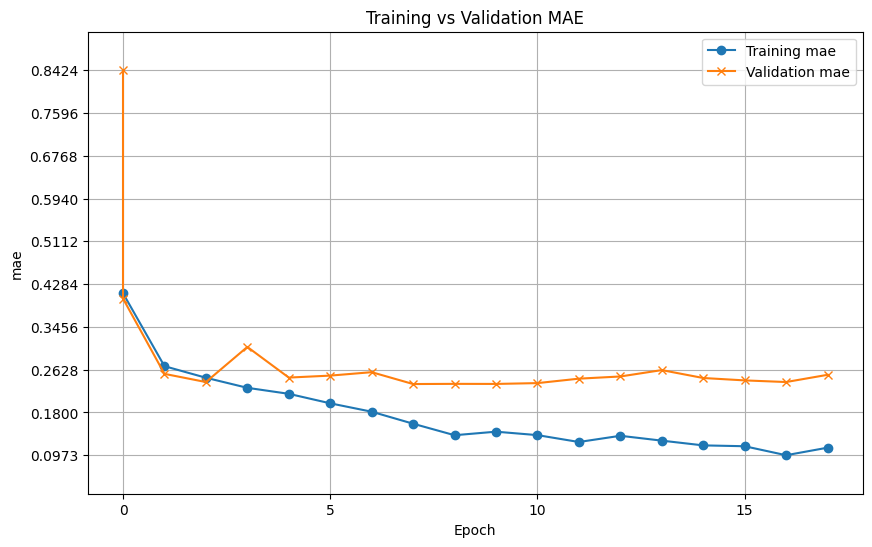

Gráfica r2 guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/r2.png


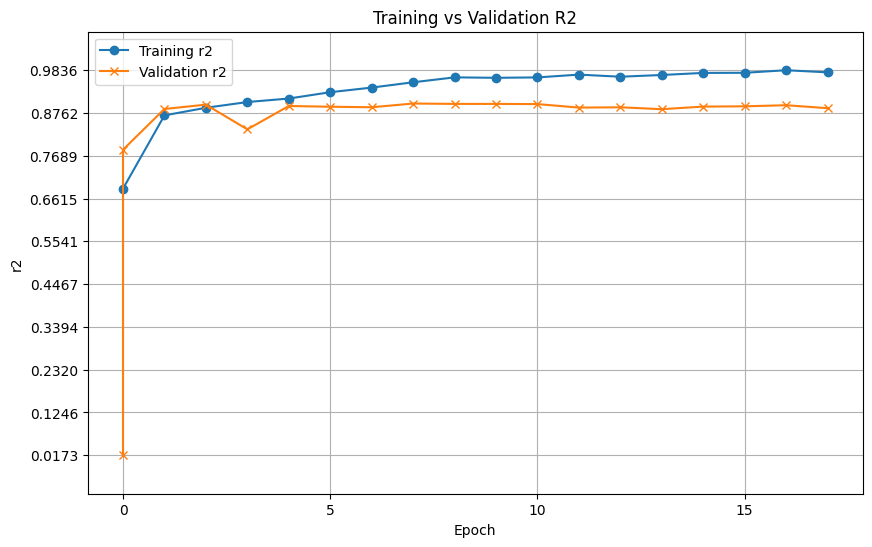

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Nombres de los archivos CSV de training y validation
train_csv = logs_path + "/training_logs_resnet18.csv"
val_csv = logs_path + "/validation_logs_resnet18.csv"

# Cargar datos
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

# Métricas a graficar
metrics = ["loss", "mse", "rmse", "mae", "r2"]

# Rango de epocas para ticks en X
epoch_min = min(train_df['epoch'].min(), val_df['epoch'].min())
epoch_max = max(train_df['epoch'].max(), val_df['epoch'].max())

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['epoch'], train_df[metric], label='Training '+metric, marker='o')
    plt.plot(val_df['epoch'], val_df[metric], label='Validation '+metric, marker='x')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric.upper()}")
    plt.legend()
    plt.grid(True)

    ymin, ymax = min(train_df[metric].min(), val_df[metric].min()), max(train_df[metric].max(), val_df[metric].max())
    ymargin = (ymax - ymin) * 0.1
    plt.ylim(ymin - ymargin, ymax + ymargin)
    plt.yticks(np.linspace(ymin, ymax, 10))
    plt.xticks(np.arange(epoch_min, epoch_max + 1, 5))
       # Guardar la gráfica en logs_path con nombre basado en la métrica
    filename = os.path.join(logs_path, f"{metric}.png")
    plt.savefig(filename)
    #plt.close()

    print(f"Gráfica {metric} guardada en: {filename}")
    plt.show()

# Eligiendo modelo a probar

In [ ]:
# Ruta al checkpoint .ckpt
ckpt_path = "/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_mm/lightning_logs/version_0/checkpoints/epoch=23---val_rmse=0.08---val_loss=0.00.ckpt"
epoca = "23"

# Guardar a .pth

In [ ]:
# Carga del checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu')

# Cargar solo el diccionario de pesos
lightning_resnet18_model.load_state_dict(checkpoint['state_dict'])

lightning_resnet18_model.eval()

LightningRegressionTask(
  (model): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
torch.save(checkpoint['state_dict'], '/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_mm/lightning_logs/version_0/checkpoints/epoch_' + epoca + '.pth')